In [ ]:
import cv2
import os
for i in range(0,6):
  try:
    vidcap = cv2.VideoCapture('rc%d.mp4' % i)
    success,image = vidcap.read()
    count = 0
  except:
    print("there is no such an file")
  
  if not os.path.exists('frames%d' % i):
    os.makedirs('./frames%d/' % i)

  if os.path.exists(os.path.join(('./frames%d/' % i), '*.jpg')):
    continue
  else:
    while success:
      cv2.imwrite(os.path.join('./frames%d/' % i, "%d.jpg" % count), image)     # save frame as JPEG file 
      success,image = vidcap.read()
      print('Read a new frame: ', success)
      count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

# Inception weights ported to Pytorch from
# http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz
FID_WEIGHTS_URL = 'https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth'


class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False,
                 use_fid_inception=True):
        """Build pretrained InceptionV3
        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp


def fid_inception_v3():
    """Build pretrained Inception model for FID computation
    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.
    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = models.inception_v3(num_classes=1008,
                                    aux_logits=False,
                                    pretrained=False)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url(FID_WEIGHTS_URL, progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(models.inception.InceptionA):
    """InceptionA block patched for FID computation"""
    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(models.inception.InceptionC):
    """InceptionC block patched for FID computation"""
    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1,
                                   count_include_pad=False)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""
    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [ ]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

"""feature detection."""

import cv2
import os
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np

def feature_detection(frame):
  

  # IMG_DIR = os.path.abspath(os.path.dirname(__file__)) + './'
  IMG_DIR = './' + frame + '/'
  IMG_SIZE = (200, 200)
  
  for _file in ['pivot1.JPG', 'start.JPG', 'end.JPG']:
    
    TARGET_FILE = _file
    target_img_path = TARGET_FILE
    target_img = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)
    target_img = cv2.resize(target_img, IMG_SIZE)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    # detector = cv2.ORB_create()
    detector = cv2.AKAZE_create()
    (target_kp, target_des) = detector.detectAndCompute(target_img, None)
    
    print('TARGET_FILE: %s' % (TARGET_FILE))
    
    files = os.listdir(IMG_DIR)
    files = natsorted(files)
    ret = []
    rep = []
    count = 0
    for file in files:
      if file == '.DS_Store' or file == TARGET_FILE:
          continue
  
      comparing_img_path = os.path.join(IMG_DIR + file)
      try:
          comparing_img = cv2.imread(comparing_img_path, cv2.IMREAD_GRAYSCALE)
          comparing_img = cv2.resize(comparing_img, IMG_SIZE)
          (comparing_kp, comparing_des) = detector.detectAndCompute(comparing_img, None)
          matches = bf.match(target_des, comparing_des)
          dist = [m.distance for m in matches]
          ret.append(sum(dist) / len(dist))
          count += 1
          rep.append(count)
      except cv2.error:
          ret.append(100000)
    
      if(file == 'pivot1.JPG'):
        for i in range(len(ret)):
          if(ret[i] == np.amin(ret)):
            pivot_rep = i
      elif(file == 'start.JPG'):
        for i in range(len(ret)):
          if(ret[i] == np.amin(ret)):
            start_rep = i
      elif(file == 'end.JPG'):
        for i in range(len(ret)):
          if(ret[i] == np.amin(ret)):
            end_rep = i

  return pivot_rep

  0%|          | 0/5 [00:00<?, ?it/s]

[PosixPath('frames1/19.jpg'), PosixPath('frames1/63.jpg'), PosixPath('frames1/171.jpg'), PosixPath('frames1/169.jpg'), PosixPath('frames1/167.jpg'), PosixPath('frames1/80.jpg'), PosixPath('frames1/259.jpg'), PosixPath('frames1/181.jpg'), PosixPath('frames1/233.jpg'), PosixPath('frames1/112.jpg'), PosixPath('frames1/273.jpg'), PosixPath('frames1/99.jpg'), PosixPath('frames1/281.jpg'), PosixPath('frames1/254.jpg'), PosixPath('frames1/223.jpg'), PosixPath('frames1/58.jpg'), PosixPath('frames1/249.jpg'), PosixPath('frames1/48.jpg'), PosixPath('frames1/239.jpg'), PosixPath('frames1/40.jpg'), PosixPath('frames1/120.jpg'), PosixPath('frames1/279.jpg'), PosixPath('frames1/258.jpg'), PosixPath('frames1/92.jpg'), PosixPath('frames1/237.jpg'), PosixPath('frames1/88.jpg'), PosixPath('frames1/229.jpg'), PosixPath('frames1/23.jpg'), PosixPath('frames1/84.jpg'), PosixPath('frames1/262.jpg'), PosixPath('frames1/147.jpg'), PosixPath('frames1/149.jpg'), PosixPath('frames1/128.jpg'), PosixPath('frames1/1

  0%|          | 0/5 [00:00<?, ?it/s]

TARGET_FILE: pivot1.JPG
TARGET_FILE: start.JPG
TARGET_FILE: end.JPG
[PosixPath('frames5/19.jpg'), PosixPath('frames5/63.jpg'), PosixPath('frames5/171.jpg'), PosixPath('frames5/169.jpg'), PosixPath('frames5/167.jpg'), PosixPath('frames5/297.jpg'), PosixPath('frames5/80.jpg'), PosixPath('frames5/259.jpg'), PosixPath('frames5/181.jpg'), PosixPath('frames5/290.jpg'), PosixPath('frames5/233.jpg'), PosixPath('frames5/112.jpg'), PosixPath('frames5/273.jpg'), PosixPath('frames5/99.jpg'), PosixPath('frames5/281.jpg'), PosixPath('frames5/254.jpg'), PosixPath('frames5/223.jpg'), PosixPath('frames5/58.jpg'), PosixPath('frames5/249.jpg'), PosixPath('frames5/48.jpg'), PosixPath('frames5/239.jpg'), PosixPath('frames5/40.jpg'), PosixPath('frames5/120.jpg'), PosixPath('frames5/279.jpg'), PosixPath('frames5/258.jpg'), PosixPath('frames5/92.jpg'), PosixPath('frames5/298.jpg'), PosixPath('frames5/237.jpg'), PosixPath('frames5/88.jpg'), PosixPath('frames5/229.jpg'), PosixPath('frames5/23.jpg'), PosixPath('

100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


TARGET_FILE: pivot1.JPG
TARGET_FILE: start.JPG
TARGET_FILE: end.JPG
[0.30705314 0.2610084  0.24055792 ... 0.50948891 0.36017207 0.58371314] [0.09798435 0.08241052 0.10250707 ... 0.23252977 0.15339634 0.30839505]
FID : -12.37573844466849


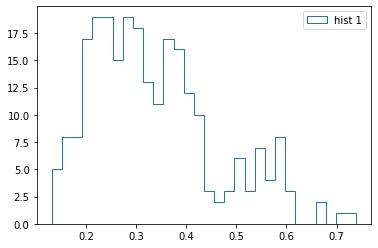

In [ ]:
 
#!/usr/bin/env python3
"""Calculates the Frechet Inception Distance (FID) to evalulate GANs
The FID metric calculates the distance between two distributions of images.
Typically, we have summary statistics (mean & covariance matrix) of one
of these distributions, while the 2nd distribution is given by a GAN.
When run as a stand-alone program, it compares the distribution of
images that are stored as PNG/JPEG at a specified location with a
distribution given by summary statistics (in pickle format).
The FID is calculated by assuming that X_1 and X_2 are the activations of
the pool_3 layer of the inception net for generated samples and real world
samples respectively.
See --help to see further details.
Code apapted from https://github.com/bioinf-jku/TTUR to use PyTorch instead
of Tensorflow
Copyright 2018 Institute of Bioinformatics, JKU Linz
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""
import os
import pathlib
import math
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab    
from scipy.stats import norm
from scipy import linalg
from imageio import imread
from torch.nn.functional import adaptive_avg_pool2d
import pickle

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

# global variables
num = 1
flag = True

# from inception import InceptionV3

# parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
# parser.add_argument('path', type=str, nargs=2,
#                     help=('Path to the generated images or '
#                           'to .npz statistic files'))
# parser.add_argument('--batch-size', type=int, default=50,
#                     help='Batch size to use')
# parser.add_argument('--dims', type=int, default=2048,
#                     choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
#                     help=('Dimensionality of Inception features to use. '
#                           'By default, uses pool3 features'))
# parser.add_argument('-c', '--gpu', default='', type=str,
#                     help='GPU to use (leave blank for CPU only)')


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if len(files) % batch_size != 0:
        print(('Warning: number of images is not a multiple of the '
               'batch size. Some samples are going to be ignored.'))
    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    n_batches = len(files) // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))

    plt_pred = []

    for i in tqdm(range(n_batches)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i * batch_size
        end = start + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.shape[2] != 1 or pred.shape[3] != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))
        
        # _pred = list(map(lambda x: x[0], map(lambda y: y[0], pred[i].cpu().data.numpy())))
        # print(_pred[0])
        # plt_pred.append(_pred[0])
        # plt_pred, = plt.plot(i, _pred[0], '-o')

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(batch_size, -1)

    if verbose:
        print(' done')
    
    # plot
    # plt.plot(range(n_batches), plt_pred, '-o', label='frame')
    # plt.legend()
    # plt.show()

    # print(pred_arr)

    return pred_arr
    

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    # assert sigma1.shape == sigma2.shape, \
    #     'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(path, files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    global num
    global flag
    
    act = get_activations(files, model, batch_size, dims, cuda, verbose)

    weighted = weight_creation(path, act)
    
    # weighted average and standard deviation
    mu, sigma = weighted_avg_and_std(act, weighted)

    # normal
    # mu = np.mean(act, axis=0)
    # sigma = np.cov(act, rowvar=False)
    
    if flag:
      # plt.plot(range(len(act)), list(map(lambda x: x[0], act)), '-b')
      n, _bins, _ = plt.hist(list(map(lambda x: x[0], act)), bins=30, histtype="step", label="hist %d" % num)
      # y = norm.pdf(bins, mu, sigma)
      # bins_center = 0.5 * (n[1:]+n[:-1])
      # _bins = np.array(_bins).reshape(-1)
      # plt.plot(_bins, n, label="line %d" % num)
      flag = False
      
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    _path = path
    
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        print(files)
        m, s = calculate_activation_statistics(_path, files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    # for p in paths:
    #     if not os.path.exists(p):
    #         raise RuntimeError('Invalid path: %s' % p)

    global flag
    global num
    
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    # print(model)

    num = int(paths[0][-1])
    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    # print(m1, s1)
    num = int(paths[1][-1])
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    print(m2, s2)
    s1 = s2.reshape(-1,1)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    -- values, weights : Numpy ndarrays with the same shape.
    """
    average = np.average(values, axis=0, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, axis=0, weights=weights)

    variance = np.sqrt(variance)

    return average, variance


def weight_creation(frame, act):
  """

  _weight : weight value. default is 1 (normal average)
  frames : input frames
  
  Return:
  -- weighted_arr : weight array

  """
  _weight = 5

  weighted_arr = np.ones(len(act))
  weighted_arr[feature_detection(frame.split('/')[0])] = _weight
  
  return weighted_arr

if __name__ == '__main__':

    global flag
    global num
    # comparing with other frames
    # for i in range(1, 6):
    #   flag = True
    #   for j in range(i+1, 6):
        
    #     frame1 = './frames' + str(i)
    #     frame2 = './frames' + str(j)
        
    #     fid_value = calculate_fid_given_paths([frame1, frame2], 50, cuda=True, dims=2048)
    #     print('FID of frame {} and frame {} : {}'.format(i, j, fid_value))
        
    
    frame1 = './frames1'
    frame2 = './frames5'
    # frame2 = './frames100'

    fid_value = calculate_fid_given_paths([frame1, frame2], 50, cuda=True, dims=2048)
    print('FID : {}'.format(fid_value))
    
      # plt.set_label('frames%d' % i)
      
    plt.legend()
    plt.show()


frame 1 : groud truth frames

frame 2 : repetition frames

frame 3 : repetition frames

frame 4 : frames which does not have pivot

frame 5 : frames which has pivot but not repetitive

(4.0, 0.0)

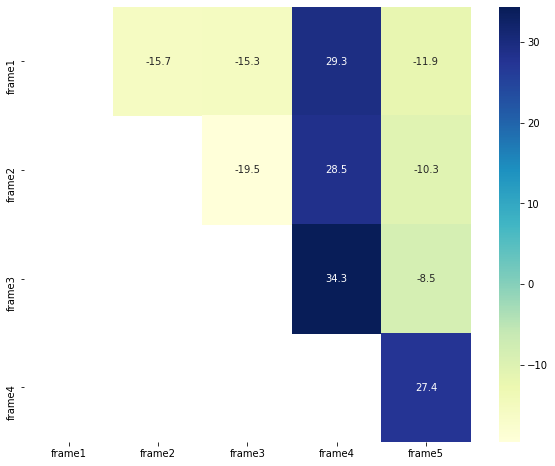

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

nan = np.nan

# average
# _list = [[nan, 48.1, 47.7, 118.1, 57.1],
#          [nan, nan, 8.57, 128.7, 76.4],
#          [nan, nan, nan, 132.8, 79.6],
#          [nan, nan, nan, nan, 146.6]]

# weighted average
_list = [[nan, -15.7, -15.3, 29.3, -11.9],
         [nan, nan, -19.5, 28.5, -10.3],
         [nan, nan, nan, 34.3, -8.5],
         [nan, nan, nan, nan, 27.4]]

xlabels = []
ylabels = []
_max = 5

for i in range(1,_max):
  xlabels.append('frame%d' % i)
  ylabels.append('frame%d' % i)

xlabels.append('frame%d' % (_max))

plt.figure(figsize=(10, 8))
ax = sns.heatmap(_list, annot=True, xticklabels=xlabels, yticklabels=ylabels, cmap="YlGnBu", fmt="1.1f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
# comparing each frame
def analy_frame(frames):
  for i in range(len(frames)):
    